Load data

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.python.lib.io.tf_record import TFRecordWriter

In [2]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True) 
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
train = pd.read_csv("data/RIROS/va_train.csv")
train = train.drop(['incidentID'], axis=1)
train.rename(columns={"Unnamed: 0": "index"}, inplace=True)
print(train.shape)
train.head()

(276, 3)


,index,label,text
0,66,C,Left femur case. The goal was to generate an A...
1,229,A,Ap RT hip was treated with the gantry in the P...
2,7,C,"The prescription indicated 6MV photons, howeve..."
3,140,C,Removal of the CT couch was done incorrectly i...
4,324,B,A prescription written by MD-1 for a patient w...


In [4]:
# load test data , here should be validation set
test = pd.read_csv('./data/RIROS/va_test.csv')
test = test.drop(['incidentID'], axis=1)
test.rename(columns={"Unnamed: 0": "index"}, inplace=True)
test['label'].replace({'A':0,'B':0, 'C':1, 'D':1},inplace=True)
test_csv = test.values
test.head()

,index,label,text
0,194,0,Radiation Oncology Technician noted a treatmen...
1,157,0,A treatment of a patient's larynx using half b...
2,225,1,Door switch malfunction at linac room caused i...
3,208,1,"During RTT pre-checks, it was found that the k..."
4,319,1,5 fraction plan was approved and loaded into A...


In [5]:
# fraction of sample pass to the train and test as example
SAMPLE_FRAC = 1
# 80% data for training and 20% data for validate
TRAIN_FRAC = 0.8
# change sentiment label form 'pos' and 'neg' to 1 and 0, which bert model knows
train['label'].replace({'A':0,'B':0, 'C':1, 'D':1},inplace=True)

In [6]:
print("Train : ", sum(train['label']==0), sum(train['label']==1))
print("Test : ", sum(test['label']==0), sum(test['label']==1))

Train :  91 185
Test :  23 46


In [7]:
train.head()

,index,label,text
0,66,1,Left femur case. The goal was to generate an A...
1,229,0,Ap RT hip was treated with the gantry in the P...
2,7,1,"The prescription indicated 6MV photons, howeve..."
3,140,1,Removal of the CT couch was done incorrectly i...
4,324,0,A prescription written by MD-1 for a patient w...


In [8]:
# train set
train_sample = train.sample(frac=SAMPLE_FRAC,random_state=0)
train_select = train_sample.sample(frac= TRAIN_FRAC,random_state=0)
train_csv = train_select.values

# validate set 
validate_select = train_sample.drop(index=train_select.index)
validate_csv = validate_select.values

Build TFRecord

In [9]:
import time
def create_tf_example(features,label):
    """
    Create tf example using features and label

    Args:
        features: list, feature list with format  ['idx','sentence']
        label: string, 

    Return:
        A binary-string of tf example.
        All proto messages can be serialized to a binary-string using the .SerializeToString method.
    """
    tf_example = tf.train.Example(features = tf.train.Features(feature = {
        'idx': tf.train.Feature(int64_list=tf.train.Int64List(value=[features[0]])),
        'sentence': tf.train.Feature(bytes_list=tf.train.BytesList(value=[features[1].encode('utf-8')])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    }))
    return tf_example.SerializeToString()

def convert_csv_to_tfrecord(csv, file_name):
    """
    Convert the numpy arryes to tfrecord and write files

    Args:
        csv: numpy arrays, each row feed (features+label)
        file_name: location TFRecord to be saved 
    """
    start_time = time.time()
    writer = TFRecordWriter(file_name)
    for idx,row in enumerate(csv):
        # check the row retionality, raise error when missing value
        try:
            if row is None:
                raise Exception('Row Missing')
            if row[0] is None or row[1] is None or row[2] is None:
                raise Exception('Value Missing')
            if row[2].strip() is '':
                raise Exception('Utterance is empty')
            
            features, label = row[[0,2]],row[1]
            example =  create_tf_example(features,label)
            writer.write(example)

        except Exception as inst:
            print(type(inst))
            print(inst.args)
            print(inst)
    writer.close()
    print(f"{file_name}: --- {(time.time() - start_time)} seconds ---")

<>:38: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:38: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-9-e82be62d8b6d>:38: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if row[2].strip() is '':


In [10]:
convert_csv_to_tfrecord(train_csv, "./data/riros_train.tfrecord")
convert_csv_to_tfrecord(validate_csv, "./data/riros_validate.tfrecord")
convert_csv_to_tfrecord(test_csv, "./data/riros_test.tfrecord")

./data/riros_train.tfrecord: --- 0.015903711318969727 seconds ---
./data/riros_validate.tfrecord: --- 0.004451274871826172 seconds ---
./data/riros_test.tfrecord: --- 0.0050089359283447266 seconds ---


In [11]:
import json
# generate exmaple number , save for use in the future 
def generate_json_info(local_file_name,df_train=[],df_val=[],df_test=[]):
    info = {"train_length": len(df_train), "validation_length": len(df_val),
            "test_length": len(df_test)}

    with open(local_file_name, 'w') as outfile:
        json.dump(info, outfile)

generate_json_info('./data/info.json',train_csv,validate_csv,test_csv)

In [12]:
tr_ds = tf.data.TFRecordDataset("data/riros_train.tfrecord")

In [13]:
# Create a description of the features.
feature_spec = {
    'idx': tf.io.FixedLenFeature([], tf.int64),
    'sentence': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}
def parse_example(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, feature_spec)
tr_parse_ds = tr_ds.map(parse_example)
dataset_iterator = iter(tr_parse_ds)

In [14]:
dataset_iterator.get_next()

{'idx': <tf.Tensor: shape=(), dtype=int64, numpy=249>,
 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 'sentence': <tf.Tensor: shape=(), dtype=string, numpy=b'The plan prescription was changed by the MD from 18Gy to 16Gy. The plan was changed in iPlan (BrainLab) and MUs were rescaled in Aria rather than reloading a new plan. The paper chart had the new plan printed and placed, but not exported. The Aria plan had errors in plan parameters and reference points that had not been updated by the dosimetrist.'>}

In [15]:
import tensorflow as tf
from transformers import *
from transformers import BertTokenizer, TFBertForSequenceClassification, glue_convert_examples_to_features
from transformers.configuration_bert import BertConfig

In [16]:
tr_ds = tf.data.TFRecordDataset("data/riros_train.tfrecord")
val_ds = tf.data.TFRecordDataset("data/riros_validate.tfrecord")
test_ds = tf.data.TFRecordDataset("data/riros_test.tfrecord")

In [17]:
# Create a description of the features.
feature_spec = {
    'idx': tf.io.FixedLenFeature([], tf.int64),
    'sentence': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}
def parse_example(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, feature_spec)

# convert the encoded string tensor into the separate tensors that will feed into the model
tr_parse_ds = tr_ds.map(parse_example)
val_parse_ds = val_ds.map(parse_example)
test_parse_ds =  test_ds.map(parse_example)

In [18]:
def clean_string(features):
    revised_sentence = tf.strings.regex_replace(features['sentence'], "\.\.\.", "", replace_global=True)
    revised_sentence = tf.strings.regex_replace(revised_sentence, "\\'", "'", replace_global=True)
    revised_sentence = tf.strings.regex_replace(revised_sentence, "\\n", "", replace_global=True)
    features['sentence'] = revised_sentence
    return features

In [19]:
tr_clean_ds = tr_parse_ds.map(lambda features: clean_string(features))
val_clean_ds = val_parse_ds.map(lambda features: clean_string(features))
test_clean_ds =  test_parse_ds.map(lambda features: clean_string(features))

In [20]:
BATCH_SIZE = 8

EVAL_BATCH_SIZE = BATCH_SIZE * 2

# XLA is the optimizing compiler for machine learning
# It can potentially increase speed by 15% with no source code changes
USE_XLA = False

# mixed precision results on https://github.com/huggingface/transformers/tree/master/examples
# Mixed precision can help to speed up training time
USE_AMP = False

In [21]:
tf.config.optimizer.set_jit(USE_XLA)
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": USE_AMP})

In [22]:
# Steps is determined by the number of examples
import json
with open('data/info.json') as json_file:
    data_info = json.load(json_file)
    
train_examples = data_info['train_length']
valid_examples = data_info['validation_length']
test_examples = data_info['test_length']

train_examples, valid_examples, test_examples

(221, 55, 69)

In [23]:
from ipywidgets import IntProgress

In [24]:
# Load tokenizer and model from pretrained model/vocabulary. Specify the number of labels to classify (2+: classification, 1: regression)
num_labels = 2 
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
import time
start_time = time.time()
train_dataset = glue_convert_examples_to_features(examples=tr_clean_ds, tokenizer=tokenizer
                                                  , max_length=128, task='sst-2',
                                                  label_list=['0','1']
                                                  )
print(f"---{time.time()-start_time} seconds---")

---0.5168788433074951 seconds---


In [26]:
import time
start_time = time.time()
valid_dataset = glue_convert_examples_to_features(examples=val_clean_ds, tokenizer=tokenizer
                                                  , max_length=128, task='sst-2'
                                                  , label_list =['0', '1'])
print(f"---{time.time()-start_time} seconds---")

---0.17525959014892578 seconds---


In [27]:
train_dataset = train_dataset.shuffle(train_examples).batch(BATCH_SIZE).repeat(-1)

valid_dataset = valid_dataset.batch(EVAL_BATCH_SIZE)

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

if USE_AMP:
    # loss scaling is currently required when using mixed precision
    opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt, 'dynamic')

loss = tf.keras.losses.BinaryCrossentropy()
#metric = tf.keras.metrics.BinaryCrossentropy('accuracy')
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [29]:
train_steps = train_examples//BATCH_SIZE
valid_steps = valid_examples//EVAL_BATCH_SIZE

In [30]:
# GPU USAGE
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices()

Num GPUs Available:  4


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:2', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:3', device_type='XLA_GPU')]

In [31]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(train_dataset, epochs=5, steps_per_epoch=train_steps,
                    validation_data=valid_dataset, validation_steps=valid_steps)

Epoch 1/5
27/27 [==============================] - 10s 389ms/step - loss: 1.3852 - accuracy: 0.4861 - val_loss: 0.7437 - val_accuracy: 0.3750
Epoch 2/5
27/27 [==============================] - 8s 279ms/step - loss: 0.6853 - accuracy: 0.4225 - val_loss: 0.7138 - val_accuracy: 0.4167
Epoch 3/5
27/27 [==============================] - 7s 277ms/step - loss: 0.6372 - accuracy: 0.4742 - val_loss: 0.6791 - val_accuracy: 0.4792
Epoch 4/5
27/27 [==============================] - 7s 277ms/step - loss: 0.5597 - accuracy: 0.4789 - val_loss: 0.6422 - val_accuracy: 0.4167
Epoch 5/5
27/27 [==============================] - 7s 276ms/step - loss: 0.5846 - accuracy: 0.3380 - val_loss: 0.6339 - val_accuracy: 0.3958


Text(0, 0.5, 'accuracy')

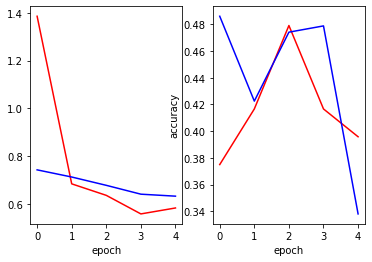

In [33]:
import matplotlib.pyplot as plt
# plot of training and validation loss
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(history.history['loss'],'r')
ax1.plot(history.history['val_loss'],'b')
ax1.set_xlabel('epoch')


ax2.plot(history.history['val_accuracy'],'r')
ax2.plot(history.history['accuracy'],'b')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')

In [34]:
import time
start_time = time.time()
test_dataset = glue_convert_examples_to_features(examples=test_clean_ds, tokenizer=tokenizer
                                                  , max_length=512, task='sst-2'
                                                  , label_list =['0', '1'])
print(f"---{time.time()-start_time} seconds---")

---0.21392035484313965 seconds---


In [35]:
test_dataset = test_dataset.batch(EVAL_BATCH_SIZE)

In [36]:
pred = model.predict(test_dataset)

In [37]:
model.evaluate(test_dataset)

5/5 [==============================] - 2s 481ms/step - loss: 0.4873 - accuracy: 0.4783


[0.48726770281791687, 0.47826087474823]

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [39]:
y_pred = np.argmax(pred[0], axis=1)
print(classification_report(np.int64(test_csv[:,1]), y_pred,labels=[0,1]))

              precision    recall  f1-score   support

           0       0.38      0.91      0.54        23
           1       0.86      0.26      0.40        46

    accuracy                           0.48        69
   macro avg       0.62      0.59      0.47        69
weighted avg       0.70      0.48      0.45        69

